# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import stan_utility
import astropy.units as u
%load_ext autoreload
%autoreload 2

## Sources

Decided to go with the astromodels package as python3 branch is working well.

To install: 
```
pip install git+https://github.com/giacomov/astromodels.git@py2to3
```

In [2]:
from python.source.simple_source import PointSource, DiffuseSource, TestSourceList
from python.source.flux_model import PowerLawSpectrum, IsotropicDiffuseBG
from python.source.parameter import Parameter

In [3]:
source = PointSource.make_powerlaw_source(
    "test", 1*u.rad, 2*u.rad, 1E55*u.erg/u.s, 2.2, 1, 1E2*u.GeV, 1E9*u.GeV)

In [4]:
source.luminosity

<Quantity 1.e+55 erg / s>

In [5]:
source.parameters["norm"].value
a = 0
a += source.flux_model.total_flux_int
print(a)

20.709727266851417 1 / (m2 s)


In [6]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'

ps_norm = Parameter(0.5*1E-11 /u.GeV/u.m**2/u.s, "ps_norm", fixed=True, par_range=(0, np.inf))
index = Parameter(2.1, "index", fixed=False, par_range=(1.1, 4))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, par_range=(0, np.inf))

source_list = TestSourceList(source_file, spectral_shape=PowerLawSpectrum(ps_norm, 1E3*u.GeV, index, lower_energy=1E2*u.GeV, upper_energy=1E11*u.GeV))

# Select sources below zth = 1
zth = 1.0
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1

diffuse_flux_model = IsotropicDiffuseBG(PowerLawSpectrum(diffuse_norm, 1E5*u.GeV, index, lower_energy=1E2*u.GeV, upper_energy=1E11*u.GeV))

diffuse_bg = DiffuseSource('diffuse_bg', zth, flux_model=diffuse_flux_model)
source_list.add(diffuse_bg)

In [7]:
f = sum([source.flux_model.total_flux_int for source in source_list[:-1]]) / source_list.total_flux_int()
print(f)

0.4476983973700851


In [8]:
source_list.sources[0].parameters["index"].value = 3
print(source_list.sources[1].parameters["norm"].value)
print(source_list.sources[0].luminosity)

5e-12 1 / (GeV m2 s)
1.7973021994896477e+46 erg / s


In [9]:
@u.quantity_input
def test(a: u.GeV):
    return a**2

test(np.ones(10) << u.GeV)

<Quantity [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.] GeV2>

In [10]:
source_list.N

38

In [11]:
source_list.total_flux_int()

<Quantity 0.00072925 1 / (m2 s)>

## Precomputation

In [12]:
from python.Precomputation import ExposureIntegral
from python.detector_model import NorthernTracksEffectiveArea
import cProfile






In [16]:
time = 8  # years
Emin = 1.0e5  # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksEffectiveArea,
                                     time, Emin)
pr = cProfile.Profile()
pr.enable()
exposure_integral()
pr.disable()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x7f2ce9b9ff50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f2ce9c51bd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f2ce9b98790> already on stack


In [17]:
pr.dump_stats("profile.stats")

/home/chrhck/miniconda3/envs/hierarchical_nu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


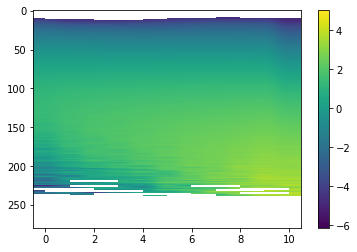

In [18]:
fig, ax = plt.subplots()
plt.imshow(np.log10(exposure_integral._effective_area._eff_area), aspect='auto')
plt.colorbar()

In [19]:
np.searchsorted(exposure_integral.par_grids[0], 2.28, )

20

In [24]:
(exposure_integral.integral_grid[-1][20] / diffuse_bg.redshift_factor(1)).to(1/u.yr)

<Quantity 6.53431563 1 / yr>

In [25]:
exposure_integral.par_grids[0][20]

2.283673469387755

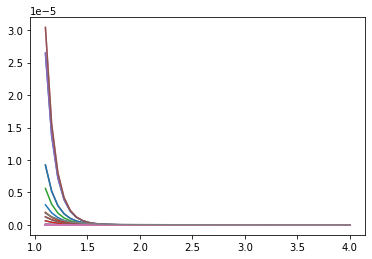

In [26]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.par_grids[0], _)

## Generate Stan code for simulation


In [17]:
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext, FunctionCall, IfBlockContext,
    ElseBlockContext, ElseIfBlockContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

In [18]:
with StanFileGenerator("stan_files/detector_model_test") as cg:
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF)
    cg.generate_files()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x7f3195c17190> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x7f3195bb4d90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195bb4610> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195bb4f90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195bb4bd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195bb4c90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x7f3195bbdc90> already on stack
INFO:pyth

In [19]:
with StanFileGenerator("stan_files/sim_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        _ = Include("energy_spectrum.stan")

    with DataContext() as dc:

        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]

        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        redshift = ForwardVariableDef("z", "vector[Ns+1]")

        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin = ForwardVariableDef("Emin", "real")

        # Flux
        Q = ForwardVariableDef("Q", "real")
        F0 = ForwardVariableDef("F0", "real")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        Ngrid_str = ["[", Ngrid, "]"]
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid",
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")

        # Inputs
        T = ForwardVariableDef("T", "real")

    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")

        # Mpc_to_m = ForwardVariableDef("Mpc_to_m", "real")
        # Mpc_to_m << StringExpression("3.086e22")

        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([Fs, " += ", F[k]])

        F[Ns + 1] << F0

        FT << (Fs + FT)
        f << (Fs / FT)

        eps << FunctionCall([T, Emin, alpha, alpha_grid, integral_grid, Ns], "get_exposure_factor")
        Nex << FunctionCall([F, eps], "get_Nex_sim")

        w_exposure << FunctionCall([F, eps], "get_exposure_weights")
        N << FunctionCall([Nex], "poisson_rng")

        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])

    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 

        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")

        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")

        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")

        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")

        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:

            lam[i] << FunctionCall([w_exposure], "categorical_rng")
            StringExpression(["print(\"lam is: \", ",lam[i], ")"])
            StringExpression(["print(\"varpi[lam] is: \", ", varpi[lam[i]], ")"])
            

            accept << 0
            ntrials << 0

            with WhileLoopContext([accept != 1]):
                with IfBlockContext([StringExpression([lam[i], "<", Ns + 1])]):
                    omega << varpi[lam[i]]
                with ElseIfBlockContext([lam[i] == Ns + 1]):
                    omega << FunctionCall([1], "sphere_rng")
                cosz[i] << FunctionCall([FunctionCall([omega], "omega_to_zenith")], "cos")

                # Sample energy

                Esrc[i] << FunctionCall([alpha, Emin * (1 + redshift[lam[i]])], "spectrum_rng")
                E[i] << Esrc[i] / (1 + redshift[lam[i]])

                # Test against Aeff
                with IfBlockContext([StringExpression([cosz[i], ">= 0.1"])]):
                    Pdet[i] << 0
                with ElseBlockContext():
                    Pdet[i] << ntd_pdf.effective_area(E[i], omega) / aeff_max

                prob[1] << Pdet[i]
                prob[2] << 1 - Pdet[i]
                StringExpression([ntrials, " += ", 1])
                # StringExpression(["print(", Pdet[i], ")"])
                with IfBlockContext([StringExpression([ntrials, "< 10000"])]):
                    accept << FunctionCall([prob], "categorical_rng")
                with ElseBlockContext():
                    accept << 1
                    StringExpression(["print(\"problem component: \", ", lam[i], ");\n"])

                #accept << StringExpression(["categorical_rng(", prob, ")"])

            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            Edet[i] << ntd_rng.energy_resolution(E[i])


    sim = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75990> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b759d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75b90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75d10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75ed0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75f90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x7f3195b75b50> already on stack
INFO:p

In [20]:
cg._base_filename

'stan_files/sim_code'

In [21]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="sim")

Using cached StanModel


## Simulation

In [53]:
def to_unit_vector(dec, ra):
    theta = dec + np.pi/2
    x = np.sin(theta) * np.cos(ra)
    y = np.sin(theta) * np.sin(ra)
    z = np.cos(theta)
    return [x, y, z]

In [54]:
redshift = [source_list.sources[i].redshift for i in range(source_list.N)]
lum_dist = [luminosity_distance(_) for _ in redshift]
varpi = np.asarray([to_unit_vector(*np.radians(source_list.sources[i].coord)) for i in range(source_list.N-1)])

In [56]:
# Inputs 
inputs = {}
inputs['Ns'] = source_list.N-1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi

inputs['Ngrid'] = len(exposure_integral.par_grids[0])
inputs['alpha_grid'] = exposure_integral.par_grids[0]
inputs['integral_grid'] = exposure_integral.integral_grid

inputs['aeff_max'] = np.max(exposure_integral.effective_area._eff_area)

In [57]:
#inputs['aeff_max'] = 1e4

In [58]:
inputs['alpha'] = 2.0
inputs['Emin'] = 1e5 # GeV

total_flux = source_list.total_flux_int() # m^-2 s^-1

inputs['T'] = 1 * 3.154E7 # s
inputs['F0'] = ((1 - f) * total_flux) # m^-2 yr^-1
inputs['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*3.086e22)**2) 
                                          for d in inputs['D']])) )  # yr^-1

In [59]:
# Simulate
simulation = sm.sampling(data=inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

RuntimeError: Exception: sim_d88129c6ab6e4ec5000246aa7c2eff53_namespace::write_array: omega is not a valid unit vector. The sum of the squares of the elements should be 1, but is nan  (in 'unknown file name' at line 1058)


In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u

class Direction():
    """
    Input the unit vector vMF samples and
    store x, y, and z and galactic coordinates
    of direction in Mpc.
    """

    def __init__(self, unit_vector_3d):
        """
        Input the unit vector samples and
        store x, y, and z and galactic coordinates
        of direction in Mpc.

        :param unit_vector_3d: a 3-dimensional unit vector.
        """

        self.unit_vector = unit_vector_3d
        transposed_uv = np.transpose(self.unit_vector)
        self.x = transposed_uv[0]
        self.y = transposed_uv[1]
        self.z = transposed_uv[2]
        self.d = SkyCoord(self.x, self.y, self.z,
                          unit = 'mpc',
                          representation_type = 'cartesian',
                          frame = 'icrs')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [26]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad


true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [27]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  42
Nbg:  50
w_bg:  0.5434782608695652


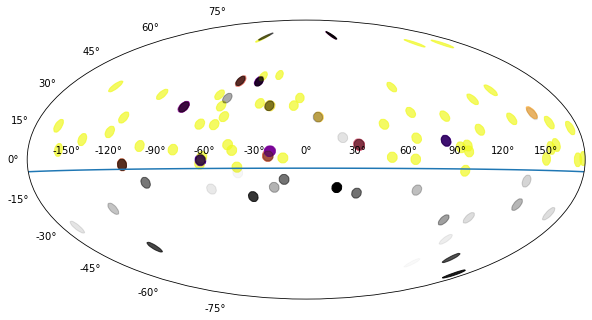

In [28]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circle = mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7)
    ax.add_patch(circle)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circle = mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm)
    ax.add_patch(circle)
ax.axhline(np.deg2rad(-5))

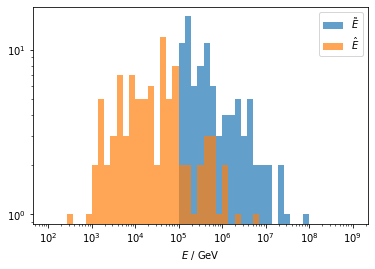

In [29]:
# Plot energies
Emin_cascades = inputs['Emin']
bins = np.logspace(np.log(Emin_cascades/1000), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(10**Edet, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Generate Stan code for fit

In [30]:
from backend.stan_generator import ParametersContext, TransformedParametersContext
from backend.variable_definitions import ParameterDef, ParameterVectorDef

In [31]:
with StanFileGenerator("stan_files/model_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("energy_spectrum.stan")
        ntd = NorthernTracksDetectorModel()
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Emin = ForwardVariableDef("Emin", "real")
        
         # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        redshift = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        
        zenith = ForwardVariableDef("zenith", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            zenith[i] << StringExpression(["pi() - acos(", omega[i][3], ")"])
            
    with ParametersContext() as pc:
        
        Q = ParameterDef("Q", "real", 0.0, 1e60)
        F0 = ParameterDef("F0", "real", 0.0, 500)
        
        alpha = ParameterDef("alpha", "real", 1.5, 3.5)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Emin, 1e8)
        
    with TransformedParametersContext() as tpc:
        
        Fs = ParameterDef("Fs", "real", 0.0)
    
    model = cg.generate_single_file()

INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x119d6db10> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x119d6db90> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x119aba1d0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x11952e110> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x1192e5fd0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x1196360d0> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.DefinitionContext object at 0x119d5b050> already on stack
INFO:backend.code_generator:Object of type <backend.stan_generator.FunctionsContext object at 0x119d5ba10> already on stack
INFO

In [32]:
a = None
not a

True